<a href="https://colab.research.google.com/github/scpepper69/ml-learning-materials/blob/master/TensorFlow_Keras_ObjectDetection_01_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI・機械学習 勉強会 #2
## - SSD:Single Shot Multibox Detectorによる物体検知(Object Detection)の実装 -


※ まえがき

XXXX

## 目次

  
2.1.   概要

2.2.   実装プロセス

1.   環境準備
・・・








---



##2.1 概要
TensorFlow + KerasによるSSDの実装に触れ、Object Detectionの考え方と実装方法を学習します。

Object Detectionは、様々な実装方式が発明されており、非常に活発に研究が行われている分野です。

* R-CNN
* Fast/Faster R-CNN
* YOLO
* SSD

ここでは、SSD:Single Shot Multibox Detectorを取り上げ、Kerasでの実装を行います。

MLPおよびCNNでは、Sequentialなモデル構造でしたが、Object Detectionを行うモデルはSequentialでない複雑なモデルとなりますし、損失関数も自前で定義する必要があります。

なお、本notebookでは、順々にソースを追って理解していけるよう、各クラスやファンクションもすべてベタ書きしています。

ソースコードはPython3を前提に書いてあります。また、学習に時間がかかるため、Google ColabではGPUランタイムを使ってください。


In [1]:
# TensorFlowバージョンは1.13.1の前提
!pip install scipy==1.2.1
!pip install tensorflow-estimator==1.13.0 tensorflow-gpu==1.13.1

     |████████████████████████████████| 24.8MB 1.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.0
    Uninstalling scipy-1.3.0:
      Successfully uninstalled scipy-1.3.0
     |████████████████████████████████| 368kB 2.2MB/s 
     |████████████████████████████████| 345.2MB 58kB/s 
ERROR: tensorflow 1.14.0rc1 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.14.0rc1
    Uninstalling tensorflow-estimator-1.14.0rc1:
      Successfully uninstalled tensorflow-estimator-1.14.0rc1


Google Colabratoryは、ランタイムが初期化されるとデータも失われます。

学習した中のチェックポイントが学習済みモデルを再利用できるよう、Google Driveをマウントし、ここに出力できるようしておきましょう。

In [0]:
import os, shutil
from google.colab import drive
drive.mount('/content/drive/')
gdrive_base='/content/drive/My Drive/Colab Notebooks/'

# TensorBorad用ログ
log_dir=gdrive_base+'ObjectDetection/logs/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# チェックポイントおよび学習済みモデルファイル
model_dir=gdrive_base+'ObjectDetection/model/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    

実装に必要なライブラリをインポートしておきます。

In [0]:
# 各種ライブラリインポート
import pickle
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

# モデル構築用ライブラリをインポート
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Reshape, Dropout, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler

SSDの実装に必要なカスタムレイヤーを実装します。

レイヤーごとにクラスを定義しています。

* Normalize
* PriorBox


In [0]:
class Normalize(Layer):
    """Normalization layer as described in ParseNet paper.
    # Arguments
        scale: Default feature scale.
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        Same as input
    # References
        http://cs.unc.edu/~wliu/papers/parsenet.pdf
    #TODO
        Add possibility to have one scale for all features.
    """
    def __init__(self, scale, **kwargs):
        self.axis = 3
#        if K.image_dim_ordering() == 'tf':
#            self.axis = 3
#        else:
#            self.axis = 1
        self.scale = scale
        super(Normalize, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (input_shape[self.axis],)
        init_gamma = self.scale * np.ones(shape)
        self.gamma = K.variable(init_gamma, name='{}_gamma'.format(self.name))
        self._trainable_weights = [self.gamma]
#        super(Normalize, self).build(input_shape)    # ADD 20190620

    def call(self, x, mask=None):
        output = K.l2_normalize(x, self.axis)
        output *= self.gamma
        return output


class PriorBox(Layer):
    """Generate the prior boxes of designated sizes and aspect ratios.
    # Arguments
        img_size: Size of the input image as tuple (w, h).
        min_size: Minimum box size in pixels.
        max_size: Maximum box size in pixels.
        aspect_ratios: List of aspect ratios of boxes.
        flip: Whether to consider reverse aspect ratios.
        variances: List of variances for x, y, w, h.
        clip: Whether to clip the prior's coordinates
            such that they are within [0, 1].
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        3D tensor with shape:
        (samples, num_boxes, 8)
    # References
        https://arxiv.org/abs/1512.02325
    #TODO
        Add possibility not to have variances.
        Add Theano support
    """
    def __init__(self, img_size, min_size, max_size=None, aspect_ratios=None,
                 flip=True, variances=[0.1], clip=True, **kwargs):

        self.waxis = 2
        self.haxis = 1
#        if K.image_dim_ordering() == 'tf':
#            self.waxis = 2
#            self.haxis = 1
#        else:
#            self.waxis = 3
#            self.haxis = 2
        self.img_size = img_size
        if min_size <= 0:
            raise Exception('min_size must be positive.')
        self.min_size = min_size
        self.max_size = max_size
        self.aspect_ratios = [1.0]
        if max_size:
            if max_size < min_size:
                raise Exception('max_size must be greater than min_size.')
            self.aspect_ratios.append(1.0)
        if aspect_ratios:
            for ar in aspect_ratios:
                if ar in self.aspect_ratios:
                    continue
                self.aspect_ratios.append(ar)
                if flip:
                    self.aspect_ratios.append(1.0 / ar)
        self.variances = np.array(variances)
        self.clip = True
        super(PriorBox, self).__init__(**kwargs)

    def get_output_shape_for(self, input_shape):
        num_priors_ = len(self.aspect_ratios)
        layer_width = input_shape[self.waxis]
        layer_height = input_shape[self.haxis]
        num_boxes = num_priors_ * layer_width * layer_height
        return input_shape[0], num_boxes, 8

    # support for Keras 2.0
    def compute_output_shape(self, input_shape):
        return self.get_output_shape_for(input_shape)

    def call(self, x, mask=None):
        if hasattr(x, '_keras_shape'):
            input_shape = x._keras_shape
        elif hasattr(K, 'int_shape'):
            input_shape = K.int_shape(x)
        layer_width = input_shape[self.waxis]
        layer_height = input_shape[self.haxis]
        img_width = self.img_size[0]
        img_height = self.img_size[1]
        # define prior boxes shapes
        box_widths = []
        box_heights = []
        for ar in self.aspect_ratios:
            if ar == 1 and len(box_widths) == 0:
                box_widths.append(self.min_size)
                box_heights.append(self.min_size)
            elif ar == 1 and len(box_widths) > 0:
                box_widths.append(np.sqrt(self.min_size * self.max_size))
                box_heights.append(np.sqrt(self.min_size * self.max_size))
            elif ar != 1:
                box_widths.append(self.min_size * np.sqrt(ar))
                box_heights.append(self.min_size / np.sqrt(ar))
        box_widths = 0.5 * np.array(box_widths)
        box_heights = 0.5 * np.array(box_heights)
        # define centers of prior boxes
        step_x = img_width / layer_width
        step_y = img_height / layer_height
        linx = np.linspace(0.5 * step_x, img_width - 0.5 * step_x,
                           layer_width)
        liny = np.linspace(0.5 * step_y, img_height - 0.5 * step_y,
                           layer_height)
        centers_x, centers_y = np.meshgrid(linx, liny)
        centers_x = centers_x.reshape(-1, 1)
        centers_y = centers_y.reshape(-1, 1)
        # define xmin, ymin, xmax, ymax of prior boxes
        num_priors_ = len(self.aspect_ratios)
        prior_boxes = np.concatenate((centers_x, centers_y), axis=1)
        prior_boxes = np.tile(prior_boxes, (1, 2 * num_priors_))
        prior_boxes[:, ::4] -= box_widths
        prior_boxes[:, 1::4] -= box_heights
        prior_boxes[:, 2::4] += box_widths
        prior_boxes[:, 3::4] += box_heights
        prior_boxes[:, ::2] /= img_width
        prior_boxes[:, 1::2] /= img_height
        prior_boxes = prior_boxes.reshape(-1, 4)
        if self.clip:
            prior_boxes = np.minimum(np.maximum(prior_boxes, 0.0), 1.0)
        # define variances
        num_boxes = len(prior_boxes)
        if len(self.variances) == 1:
            variances = np.ones((num_boxes, 4)) * self.variances[0]
        elif len(self.variances) == 4:
            variances = np.tile(self.variances, (num_boxes, 1))
        else:
            raise Exception('Must provide one or four variances.')
        prior_boxes = np.concatenate((prior_boxes, variances), axis=1)
        prior_boxes_tensor = K.expand_dims(K.variable(prior_boxes), 0)
        if K.backend() == 'tensorflow':
            pattern = [tf.shape(x)[0], 1, 1]
            prior_boxes_tensor = tf.tile(prior_boxes_tensor, pattern)
        elif K.backend() == 'theano':
            #TODO
            pass
        return prior_boxes_tensor

###2.x.x モデルの構築

SSDモデルを構築します。

参考：

https://qiita.com/GushiSnow/items/8c946208de0d6a4e31e7

https://qiita.com/PonDad/items/6f9e6d9397951cadc6be


In [0]:
# SSD300モデル構築

def SSD300v2(input_shape, num_classes=21):
    """SSD300 architecture.
    # Arguments
        input_shape: Shape of the input image (300, 300, 3)
        num_classes: Number of classes including background.
    # References
        https://arxiv.org/abs/1512.02325
    """
    # Input Layer
    input_layer = Input(shape=input_shape)
   
    # Block 1
    conv1_1 = Conv2D(64, (3, 3), name='conv1_1', padding='same', activation='relu')(input_layer)
    conv1_2 = Conv2D(64, (3, 3), name='conv1_2', padding='same', activation='relu')(conv1_1)
    pool1 = MaxPooling2D(name='pool1', pool_size=(2, 2), strides=(2, 2), padding='same', )(conv1_2)

    # Block 2
    conv2_1 = Conv2D(128, (3, 3), name='conv2_1', padding='same', activation='relu')(pool1)
    conv2_2 = Conv2D(128, (3, 3), name='conv2_2', padding='same', activation='relu')(conv2_1)
    pool2 = MaxPooling2D(name='pool2', pool_size=(2, 2), strides=(2, 2), padding='same')(conv2_2)

    # Block 3
    conv3_1 = Conv2D(256, (3, 3), name='conv3_1', padding='same', activation='relu')(pool2)
    conv3_2 = Conv2D(256, (3, 3), name='conv3_2', padding='same', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, (3, 3), name='conv3_3', padding='same', activation='relu')(conv3_2)
    pool3 = MaxPooling2D(name='pool3', pool_size=(2, 2), strides=(2, 2), padding='same')(conv3_3)

    # Block 4
    conv4_1 = Conv2D(512, (3, 3), name='conv4_1', padding='same', activation='relu')(pool3)
    conv4_2 = Conv2D(512, (3, 3), name='conv4_2', padding='same', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, (3, 3), name='conv4_3', padding='same', activation='relu')(conv4_2)
    pool4 = MaxPooling2D(name='pool4', pool_size=(2, 2), strides=(2, 2), padding='same')(conv4_3)

    # Block 5
    conv5_1 = Conv2D(512, (3, 3), name='conv5_1', padding='same', activation='relu')(pool4)
    conv5_2 = Conv2D(512, (3, 3), name='conv5_2', padding='same', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, (3, 3), name='conv5_3', padding='same', activation='relu')(conv5_2)
    pool5 = MaxPooling2D(name='pool5', pool_size=(3, 3), strides=(1, 1), padding='same')(conv5_3)

    # FC6
    fc6 = Conv2D(1024, (3, 3), name='fc6', dilation_rate=(6, 6), padding='same', activation='relu')(pool5)
    # x = Dropout(0.5, name='drop6')(x)

    # FC7
    fc7 = Conv2D(1024, (1, 1), name='fc7', padding='same', activation='relu')(fc6)
    # x = Dropout(0.5, name='drop7')(x)

    # Block 6
    conv6_1 = Conv2D(256, (1, 1), name='conv6_1', padding='same', activation='relu')(fc7)
    conv6_2 = Conv2D(512, (3, 3), name='conv6_2', strides=(2, 2), padding='same', activation='relu')(conv6_1)

    # Block 7
    conv7_1 = Conv2D(128, (1, 1), name='conv7_1', padding='same', activation='relu')(conv6_2)
    conv7_1z = ZeroPadding2D(name='conv7_1z')(conv7_1)
    conv7_2 = Conv2D(256, (3, 3), name='conv7_2', padding='valid', strides=(2, 2), activation='relu')(conv7_1z)

    # Block 8
    conv8_1 = Conv2D(128, (1, 1), name='conv8_1', padding='same', activation='relu')(conv7_2)
    conv8_2 = Conv2D(256, (3, 3), name='conv8_2', padding='same', strides=(2, 2), activation='relu')(conv8_1)

    # Last Pool
    pool6 = GlobalAveragePooling2D(name='pool6')(conv8_2)

    
    # Prediction from conv4_3
    num_priors = 3
    img_size = (input_shape[1], input_shape[0])
    name = 'conv4_3_norm_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)

    conv4_3_norm = Normalize(20, name='conv4_3_norm')(conv4_3)
    conv4_3_norm_mbox_loc = Conv2D(num_priors * 4, (3, 3), name='conv4_3_norm_mbox_loc', padding='same')(conv4_3_norm)
    conv4_3_norm_mbox_loc_flat = Flatten(name='conv4_3_norm_mbox_loc_flat')(conv4_3_norm_mbox_loc)
    conv4_3_norm_mbox_conf = Conv2D(num_priors * num_classes, (3, 3), name=name, padding='same')(conv4_3_norm)
    conv4_3_norm_mbox_conf_flat = Flatten(name='conv4_3_norm_mbox_conf_flat')(conv4_3_norm_mbox_conf)
    conv4_3_norm_mbox_priorbox = PriorBox(img_size, 30.0, name='conv4_3_norm_mbox_priorbox', aspect_ratios=[2], variances=[0.1, 0.1, 0.2, 0.2])(conv4_3_norm)

    # Prediction from fc7
    num_priors = 6
    name = 'fc7_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)

    fc7_mbox_conf = Conv2D(num_priors * num_classes, (3, 3), padding='same', name=name)(fc7)
    fc7_mbox_conf_flat = Flatten(name='fc7_mbox_conf_flat')(fc7_mbox_conf)
    fc7_mbox_loc = Conv2D(num_priors * 4, (3, 3), name='fc7_mbox_loc', padding='same')(fc7)
    fc7_mbox_loc_flat = Flatten(name='fc7_mbox_loc_flat')(fc7_mbox_loc)
    fc7_mbox_priorbox = PriorBox(img_size, 60.0, name='fc7_mbox_priorbox', max_size=114.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2])(fc7)

    # Prediction from conv6_2
    num_priors = 6
    name = 'conv6_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)

    conv6_2_mbox_conf = Conv2D(num_priors * num_classes, (3, 3), padding='same', name=name)(conv6_2)
    conv6_2_mbox_conf_flat = Flatten(name='conv6_2_mbox_conf_flat')(conv6_2_mbox_conf)
    conv6_2_mbox_loc = Conv2D(num_priors * 4, (3, 3,), name='conv6_2_mbox_loc', padding='same')(conv6_2)
    conv6_2_mbox_loc_flat = Flatten(name='conv6_2_mbox_loc_flat')(conv6_2_mbox_loc)
    conv6_2_mbox_priorbox = PriorBox(img_size, 114.0, max_size=168.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='conv6_2_mbox_priorbox')(conv6_2)

    # Prediction from conv7_2
    num_priors = 6
    name = 'conv7_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)

    conv7_2_mbox_conf = Conv2D(num_priors * num_classes, (3, 3), padding='same', name=name)(conv7_2)
    conv7_2_mbox_conf_flat = Flatten(name='conv7_2_mbox_conf_flat')(conv7_2_mbox_conf)
    conv7_2_mbox_loc = Conv2D(num_priors * 4, (3, 3), padding='same', name='conv7_2_mbox_loc')(conv7_2)
    conv7_2_mbox_loc_flat = Flatten(name='conv7_2_mbox_loc_flat')(conv7_2_mbox_loc)
    conv7_2_mbox_priorbox = PriorBox(img_size, 168.0, max_size=222.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='conv7_2_mbox_priorbox')(conv7_2)

    # Prediction from conv8_2
    num_priors = 6
    name = 'conv8_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)

    conv8_2_mbox_conf = Conv2D(num_priors * num_classes, (3, 3), padding='same', name=name)(conv8_2)
    conv8_2_mbox_conf_flat = Flatten(name='conv8_2_mbox_conf_flat')(conv8_2_mbox_conf)
    conv8_2_mbox_loc = Conv2D(num_priors * 4, (3, 3), padding='same', name='conv8_2_mbox_loc')(conv8_2)
    conv8_2_mbox_loc_flat = Flatten(name='conv8_2_mbox_loc_flat')(conv8_2_mbox_loc)
    conv8_2_mbox_priorbox = PriorBox(img_size, 222.0, max_size=276.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='conv8_2_mbox_priorbox')(conv8_2)

    # Prediction from pool6
    num_priors = 6
    name = 'pool6_mbox_conf_flat'
    if num_classes != 21:
        name += '_{}'.format(num_classes)

    target_shape = (1, 1, 256)

    pool6_mbox_loc_flat = Dense(num_priors * 4, name='pool6_mbox_loc_flat')(pool6)
    pool6_mbox_conf_flat = Dense(num_priors * num_classes, name=name)(pool6)
    pool6_reshaped = Reshape(target_shape, name='pool6_reshaped')(pool6)
    pool6_mbox_priorbox = PriorBox(img_size, 276.0, max_size=330.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='pool6_mbox_priorbox')(pool6_reshaped)

    # Gather all predictions
    mbox_loc = concatenate([conv4_3_norm_mbox_loc_flat,
                            fc7_mbox_loc_flat,
                            conv6_2_mbox_loc_flat,
                            conv7_2_mbox_loc_flat,
                            conv8_2_mbox_loc_flat,
                            pool6_mbox_loc_flat],
                           axis=1,
                           name='mbox_loc')

    mbox_conf = concatenate([conv4_3_norm_mbox_conf_flat,
                             fc7_mbox_conf_flat,
                             conv6_2_mbox_conf_flat,
                             conv7_2_mbox_conf_flat,
                             conv8_2_mbox_conf_flat,
                             pool6_mbox_conf_flat],
                            axis=1,
                            name='mbox_conf')

    mbox_priorbox = concatenate([conv4_3_norm_mbox_priorbox,
                                 fc7_mbox_priorbox,
                                 conv6_2_mbox_priorbox,
                                 conv7_2_mbox_priorbox,
                                 conv8_2_mbox_priorbox,
                                 pool6_mbox_priorbox],
                                axis=1,
                                name='mbox_priorbox')

    if hasattr(mbox_loc, '_keras_shape'):
        num_boxes = mbox_loc._keras_shape[-1] // 4
    elif hasattr(mbox_loc, 'int_shape'):
        num_boxes = K.int_shape(mbox_loc)[-1] // 4
    else:
        num_boxes = K.int_shape(mbox_loc)[-1] // 4
    
    mbox_loc = Reshape((num_boxes, 4), name='mbox_loc_final')(mbox_loc)
    mbox_conf = Reshape((num_boxes, num_classes), name='mbox_conf_logits')(mbox_conf)
    mbox_conf = Activation('softmax', name='mbox_conf_final')(mbox_conf)

    predictions = concatenate([mbox_loc,
                               mbox_conf,
                               mbox_priorbox],
                              axis=2,
                              name='predictions')

    model = Model(inputs=input_layer, outputs=predictions)

    return model

次に、学習時に必要な損失関数を定義します。

Object Detectionにおいては、物体検知の位置とクラス判別を合わせて評価する必要があるため、それを実現するために以下クラスを定義しています。

In [0]:
# 損失関数定義

class MultiboxLoss(object):
    """Multibox loss with some helper functions.
    # Arguments
        num_classes: Number of classes including background.
        alpha: Weight of L1-smooth loss.
        neg_pos_ratio: Max ratio of negative to positive boxes in loss.
        background_label_id: Id of background label.
        negatives_for_hard: Number of negative boxes to consider
            it there is no positive boxes in batch.
    # References
        https://arxiv.org/abs/1512.02325
    # TODO
        Add possibility for background label id be not zero
    """
    def __init__(self, num_classes, alpha=1.0, neg_pos_ratio=3.0,
                 background_label_id=0, negatives_for_hard=100.0):
        self.num_classes = num_classes
        self.alpha = alpha
        self.neg_pos_ratio = neg_pos_ratio
        if background_label_id != 0:
            raise Exception('Only 0 as background label id is supported')
        self.background_label_id = background_label_id
        self.negatives_for_hard = negatives_for_hard
        self.n_neg_min=0

    # 位置損失関数
    def _l1_smooth_loss(self, y_true, y_pred):
        """Compute L1-smooth loss.
        # Arguments
            y_true: Ground truth bounding boxes,
                tensor of shape (?, num_boxes, 4).
            y_pred: Predicted bounding boxes,
                tensor of shape (?, num_boxes, 4).
        # Returns
            l1_loss: L1-smooth loss, tensor of shape (?, num_boxes).
        # References
            https://arxiv.org/abs/1504.08083
        """
        abs_loss = tf.abs(y_true - y_pred)
        sq_loss = 0.5 * (y_true - y_pred)**2
        l1_loss = tf.where(tf.less(abs_loss, 1.0), sq_loss, abs_loss - 0.5)

        return tf.reduce_sum(l1_loss, -1)

    # クラス損失関数
    def _softmax_loss(self, y_true, y_pred):
        """Compute softmax loss.
        # Arguments
            y_true: Ground truth targets,
                tensor of shape (?, num_boxes, num_classes).
            y_pred: Predicted logits,
                tensor of shape (?, num_boxes, num_classes).
        # Returns
            softmax_loss: Softmax loss, tensor of shape (?, num_boxes).
        """
        #y_pred = tf.maximum(y_pred, 1e-15) # Mod 20190620
        y_pred = tf.maximum(tf.minimum(y_pred, 1 - 1e-15), 1e-15) 
        softmax_loss = -tf.reduce_sum(y_true * tf.log(y_pred), axis=-1)

        return softmax_loss

    # 位置損失関数とクラス識別損失関数を合算したマルチロス損失関数
    def compute_loss(self, y_true, y_pred):
        """Compute mutlibox loss.
        # Arguments
            y_true: Ground truth targets,
                tensor of shape (?, num_boxes, 4 + num_classes + 8),
                priors in ground truth are fictitious,
                y_true[:, :, -8] has 1 if prior should be penalized
                    or in other words is assigned to some ground truth box,
                y_true[:, :, -7:] are all 0.
            y_pred: Predicted logits,
                tensor of shape (?, num_boxes, 4 + num_classes + 8).
        # Returns
            loss: Loss for prediction, tensor of shape (?,).
        """
        batch_size = tf.shape(y_true)[0]
        num_boxes = tf.to_float(tf.shape(y_true)[1])

        # loss for all priors
        conf_loss = self._softmax_loss(y_true[:, :, 4:-8], y_pred[:, :, 4:-8])
        loc_loss = self._l1_smooth_loss(y_true[:, :, :4], y_pred[:, :, :4])

        # get positives loss
        num_pos = tf.reduce_sum(y_true[:, :, -8], axis=-1)
        pos_loc_loss = tf.reduce_sum(loc_loss * y_true[:, :, -8], axis=1)
        pos_conf_loss = tf.reduce_sum(conf_loss * y_true[:, :, -8], axis=1)

        # get negatives loss, we penalize only confidence here
        num_neg = tf.minimum(self.neg_pos_ratio * num_pos, num_boxes - num_pos)
        pos_num_neg_mask = tf.greater(num_neg, 0)
        has_min = tf.to_float(tf.reduce_any(pos_num_neg_mask))
        num_neg = tf.concat(axis=0, values=[num_neg, [(1 - has_min) * self.negatives_for_hard]])
        num_neg_batch = tf.reduce_min(tf.boolean_mask(num_neg, tf.greater(num_neg, 0)))
        num_neg_batch = tf.to_int32(num_neg_batch)
        confs_start = 4 + self.background_label_id + 1
        confs_end = confs_start + self.num_classes - 1
        max_confs = tf.reduce_max(y_pred[:, :, confs_start:confs_end], axis=2)
        _, indices = tf.nn.top_k(max_confs * (1 - y_true[:, :, -8]), k=num_neg_batch)
        batch_idx = tf.expand_dims(tf.range(0, batch_size), 1)
        batch_idx = tf.tile(batch_idx, (1, num_neg_batch))
        full_indices = (tf.reshape(batch_idx, [-1]) * tf.to_int32(num_boxes) + tf.reshape(indices, [-1]))
        # full_indices = tf.concat(2, [tf.expand_dims(batch_idx, 2),
        #                              tf.expand_dims(indices, 2)])
        # neg_conf_loss = tf.gather_nd(conf_loss, full_indices)
        neg_conf_loss = tf.gather(tf.reshape(conf_loss, [-1]), full_indices)
        neg_conf_loss = tf.reshape(neg_conf_loss, [batch_size, num_neg_batch])
        neg_conf_loss = tf.reduce_sum(neg_conf_loss, axis=1)

        # loss is sum of positives and negatives
        total_loss = pos_conf_loss + neg_conf_loss
        total_loss /= (num_pos + tf.to_float(num_neg_batch))
        num_pos = tf.where(tf.not_equal(num_pos, 0), num_pos, tf.ones_like(num_pos))
        total_loss += (self.alpha * pos_loc_loss) / num_pos

        return total_loss

    def compute_loss2(self, y_true, y_pred):
        '''
        Compute the loss of the SSD model prediction against the ground truth.
        Arguments:
            y_true (array): A Numpy array of shape `(batch_size, #boxes, #classes + 12)`,
                where `#boxes` is the total number of boxes that the model predicts
                per image. Be careful to make sure that the index of each given
                box in `y_true` is the same as the index for the corresponding
                box in `y_pred`. The last axis must have length `#classes + 12` and contain
                `[classes one-hot encoded, 4 ground truth box coordinate offsets, 8 arbitrary entries]`
                in this order, including the background class. The last eight entries of the
                last axis are not used by this function and therefore their contents are
                irrelevant, they only exist so that `y_true` has the same shape as `y_pred`,
                where the last four entries of the last axis contain the anchor box
                coordinates, which are needed during inference. Important: Boxes that
                you want the cost function to ignore need to have a one-hot
                class vector of all zeros.
            y_pred (Keras tensor): The model prediction. The shape is identical
                to that of `y_true`, i.e. `(batch_size, #boxes, #classes + 12)`.
                The last axis must contain entries in the format
                `[classes one-hot encoded, 4 predicted box coordinate offsets, 8 arbitrary entries]`.
        Returns:
            A scalar, the total multitask loss for classification and localization.
        '''
        self.neg_pos_ratio = tf.constant(self.neg_pos_ratio)
        self.n_neg_min = tf.constant(self.n_neg_min)
        self.alpha = tf.constant(self.alpha)

        batch_size = tf.shape(y_pred)[0] # Output dtype: tf.int32
        n_boxes = tf.shape(y_pred)[1] # Output dtype: tf.int32, note that `n_boxes` in this context denotes the total number of boxes per image, not the number of boxes per cell.

        # 1: Compute the losses for class and box predictions for every box.

        classification_loss = tf.to_float(self._softmax_loss(y_true[:,:,:-12], y_pred[:,:,:-12])) # Output shape: (batch_size, n_boxes)
        localization_loss = tf.to_float(self._l1_smooth_loss(y_true[:,:,-12:-8], y_pred[:,:,-12:-8])) # Output shape: (batch_size, n_boxes)

        # 2: Compute the classification losses for the positive and negative targets.

        # Create masks for the positive and negative ground truth classes.
        negatives = y_true[:,:,0] # Tensor of shape (batch_size, n_boxes)
        positives = tf.to_float(tf.reduce_max(y_true[:,:,1:-12], axis=-1)) # Tensor of shape (batch_size, n_boxes)

        # Count the number of positive boxes (classes 1 to n) in y_true across the whole batch.
        n_positive = tf.reduce_sum(positives)

        # Now mask all negative boxes and sum up the losses for the positive boxes PER batch item
        # (Keras loss functions must output one scalar loss value PER batch item, rather than just
        # one scalar for the entire batch, that's why we're not summing across all axes).
        pos_class_loss = tf.reduce_sum(classification_loss * positives, axis=-1) # Tensor of shape (batch_size,)

        # Compute the classification loss for the negative default boxes (if there are any).

        # First, compute the classification loss for all negative boxes.
        neg_class_loss_all = classification_loss * negatives # Tensor of shape (batch_size, n_boxes)
        n_neg_losses = tf.count_nonzero(neg_class_loss_all, dtype=tf.int32) # The number of non-zero loss entries in `neg_class_loss_all`
        # What's the point of `n_neg_losses`? For the next step, which will be to compute which negative boxes enter the classification
        # loss, we don't just want to know how many negative ground truth boxes there are, but for how many of those there actually is
        # a positive (i.e. non-zero) loss. This is necessary because `tf.nn.top-k()` in the function below will pick the top k boxes with
        # the highest losses no matter what, even if it receives a vector where all losses are zero. In the unlikely event that all negative
        # classification losses ARE actually zero though, this behavior might lead to `tf.nn.top-k()` returning the indices of positive
        # boxes, leading to an incorrect negative classification loss computation, and hence an incorrect overall loss computation.
        # We therefore need to make sure that `n_negative_keep`, which assumes the role of the `k` argument in `tf.nn.top-k()`,
        # is at most the number of negative boxes for which there is a positive classification loss.

        # Compute the number of negative examples we want to account for in the loss.
        # We'll keep at most `self.neg_pos_ratio` times the number of positives in `y_true`, but at least `self.n_neg_min` (unless `n_neg_loses` is smaller).
#        n_negative_keep = tf.minimum(tf.maximum(self.neg_pos_ratio * tf.to_int32(n_positive), self.n_neg_min), n_neg_losses)
        n_negative_keep = tf.minimum(tf.maximum(tf.to_int32(self.neg_pos_ratio) * tf.to_int32(n_positive), self.n_neg_min), n_neg_losses)

        # In the unlikely case when either (1) there are no negative ground truth boxes at all
        # or (2) the classification loss for all negative boxes is zero, return zero as the `neg_class_loss`.
        def f1():
            return tf.zeros([batch_size])
        # Otherwise compute the negative loss.
        def f2():
            # Now we'll identify the top-k (where k == `n_negative_keep`) boxes with the highest confidence loss that
            # belong to the background class in the ground truth data. Note that this doesn't necessarily mean that the model
            # predicted the wrong class for those boxes, it just means that the loss for those boxes is the highest.

            # To do this, we reshape `neg_class_loss_all` to 1D...
            neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1]) # Tensor of shape (batch_size * n_boxes,)
            # ...and then we get the indices for the `n_negative_keep` boxes with the highest loss out of those...
            values, indices = tf.nn.top_k(neg_class_loss_all_1D,
                                          k=n_negative_keep,
                                          sorted=False) # We don't need them sorted.
            # ...and with these indices we'll create a mask...
            negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1),
                                           updates=tf.ones_like(indices, dtype=tf.int32),
                                           shape=tf.shape(neg_class_loss_all_1D)) # Tensor of shape (batch_size * n_boxes,)
            negatives_keep = tf.to_float(tf.reshape(negatives_keep, [batch_size, n_boxes])) # Tensor of shape (batch_size, n_boxes)
            # ...and use it to keep only those boxes and mask all other classification losses
            neg_class_loss = tf.reduce_sum(classification_loss * negatives_keep, axis=-1) # Tensor of shape (batch_size,)
            return neg_class_loss

        neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)

        class_loss = pos_class_loss + neg_class_loss # Tensor of shape (batch_size,)

        # 3: Compute the localization loss for the positive targets.
        #    We don't compute a localization loss for negative predicted boxes (obviously: there are no ground truth boxes they would correspond to).

        loc_loss = tf.reduce_sum(localization_loss * positives, axis=-1) # Tensor of shape (batch_size,)

        # 4: Compute the total loss.

        total_loss = (class_loss + self.alpha * loc_loss) / tf.maximum(1.0, n_positive) # In case `n_positive == 0`
        # Keras has the annoying habit of dividing the loss by the batch size, which sucks in our case
        # because the relevant criterion to average our loss over is the number of positive boxes in the batch
        # (by which we're dividing in the line above), not the batch size. So in order to revert Keras' averaging
        # over the batch size, we'll have to multiply by it.
        total_loss = total_loss * tf.to_float(batch_size)

        return total_loss

モデルをコンパイルし、サマリ情報を確認してみましょう。

In [7]:
from tensorflow.keras.optimizers import Adam, SGD

voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1
input_shape = (300, 300, 3)

model = SSD300v2(input_shape, num_classes=NUM_CLASSES)

base_lr = 3e-4

#optim = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False) #ADD 20190620
optim = Adam(lr=base_lr)

loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss
#loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=3.0).compute_loss
model.compile(optimizer='Adadelta', loss=loss)
#model.compile(optimizer=optim, loss=loss)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 300, 300, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 1

モデル構造を図示します。今回はKerasに備わっているplot_modelというツールを用います。

非常に大きなモデル構造で、jupyter notebook上では見づらいので、ダウンロードしてローカルで確認することをお勧めします。


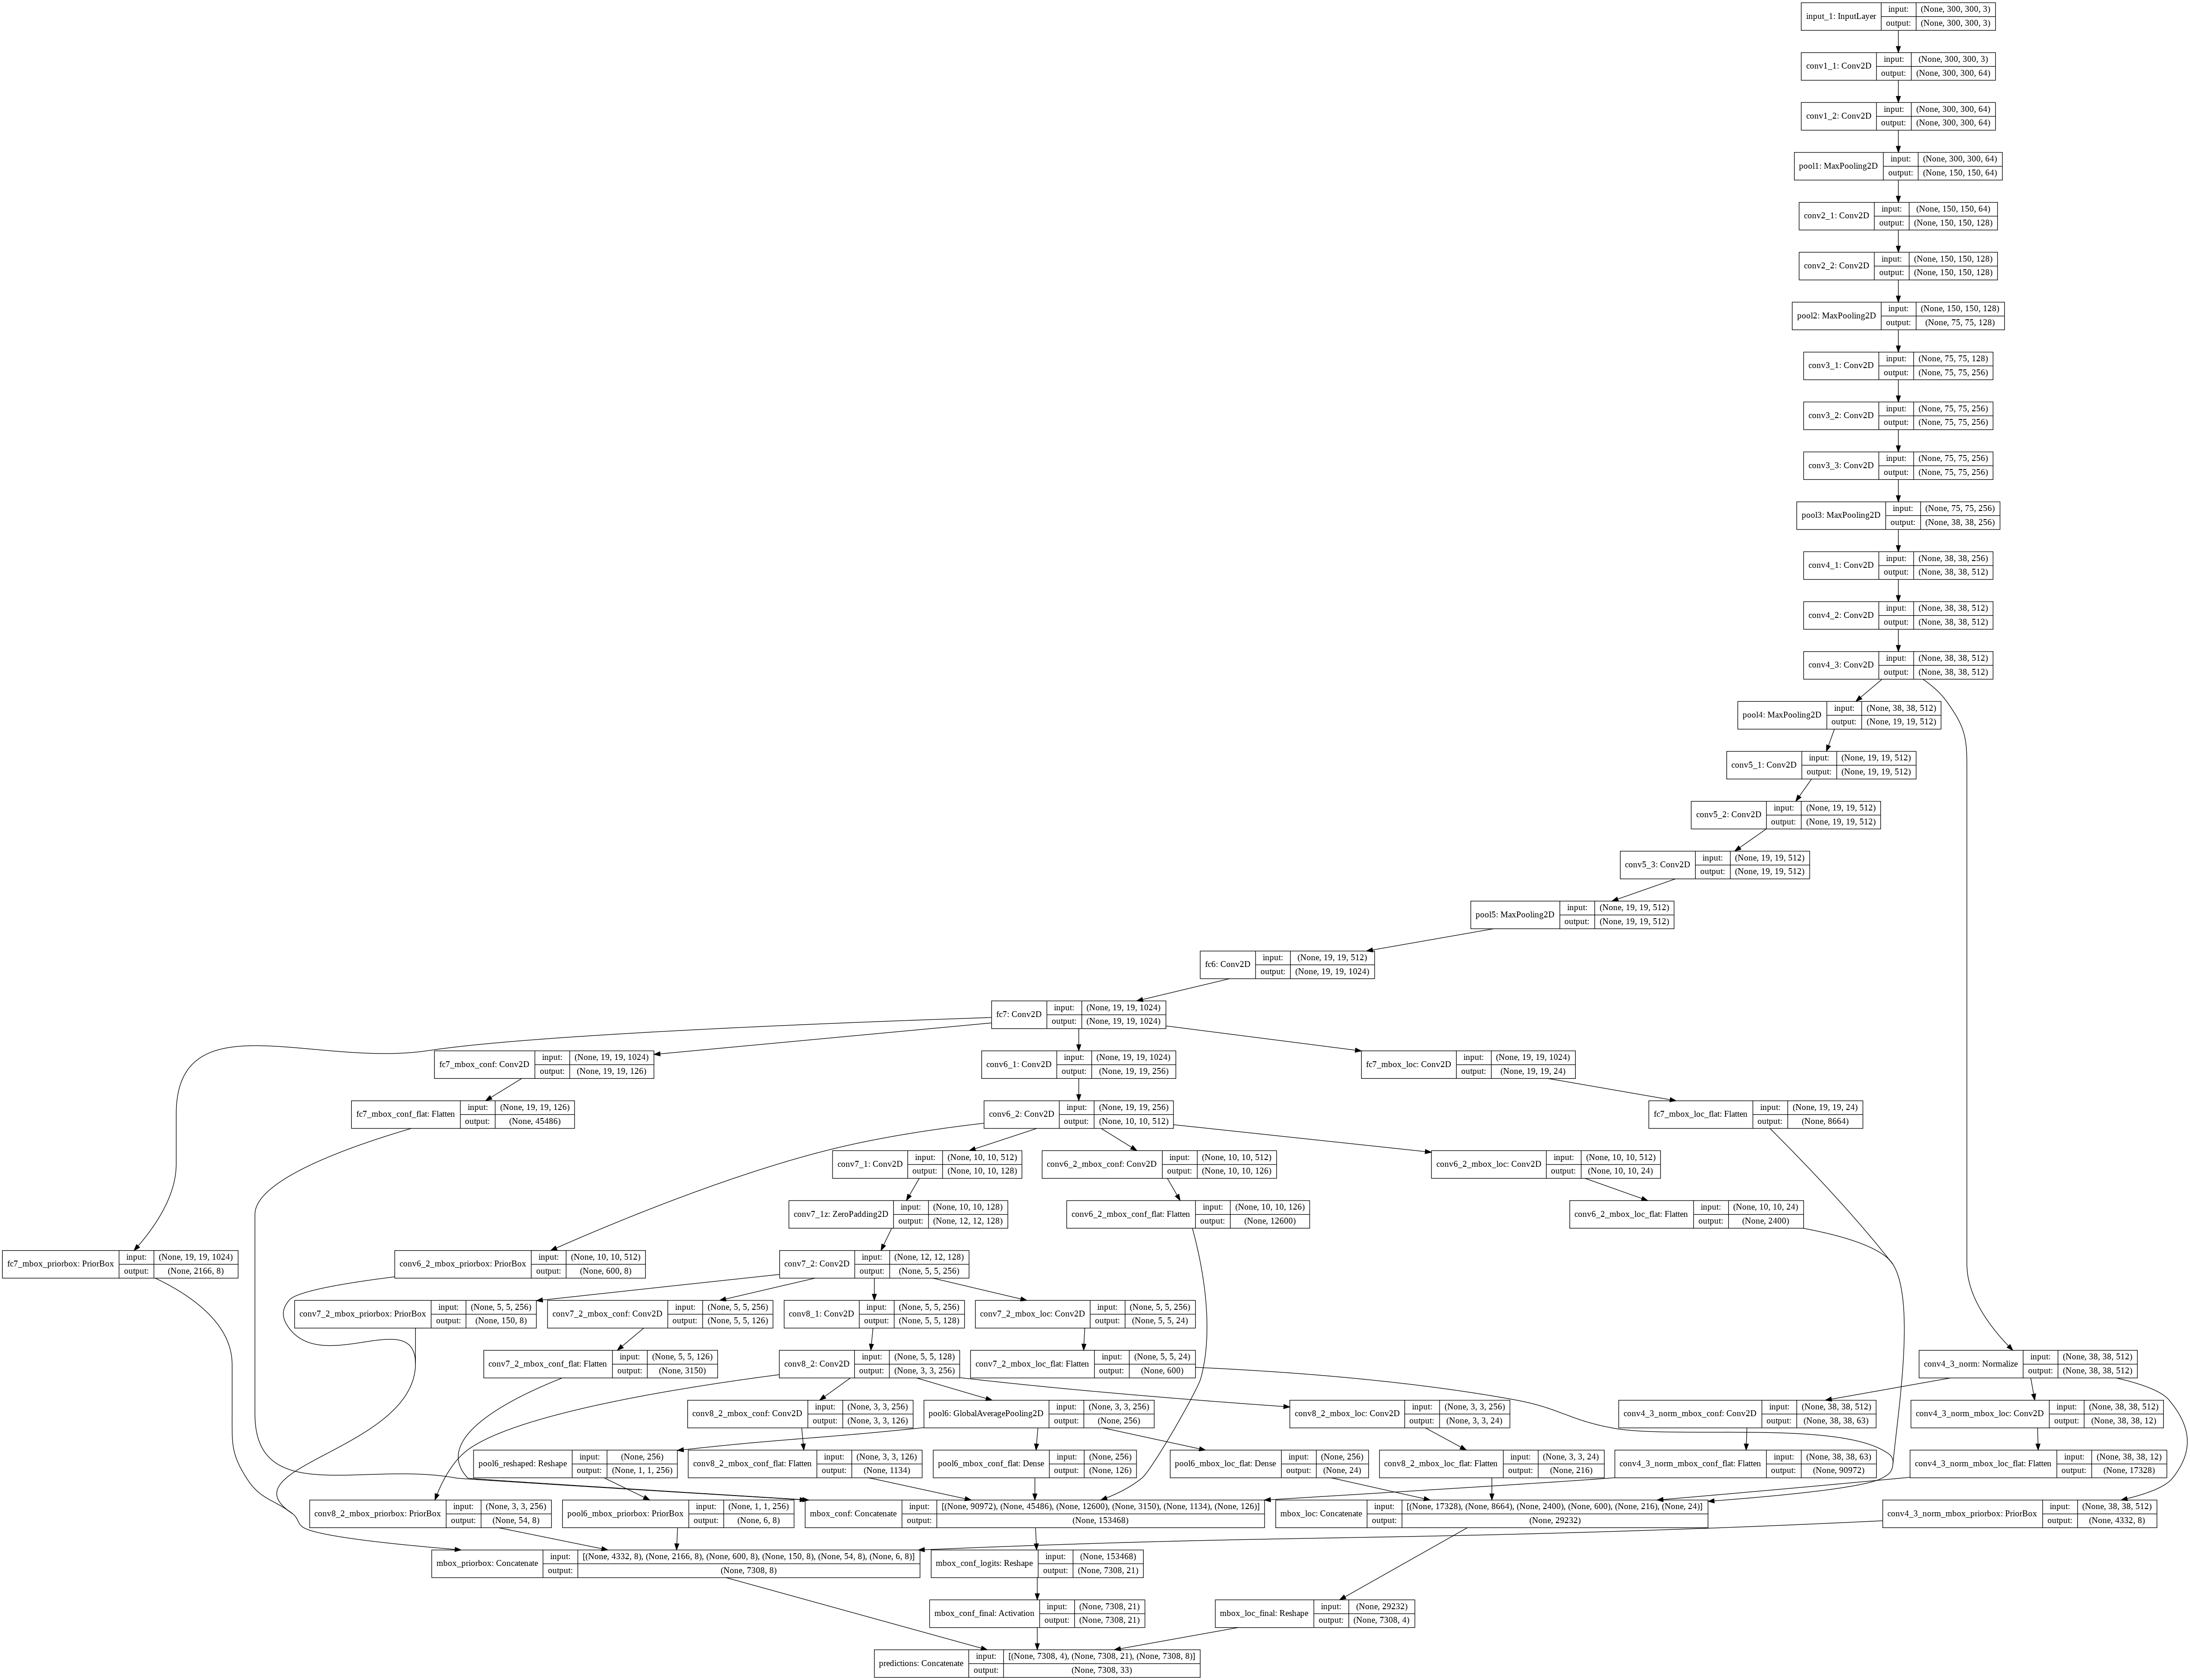

In [8]:
from tensorflow.python.keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file=f"{model_dir}/model.png", show_shapes=True)
Image(f"{model_dir}/model.png")

物体検知の領域のボックスを制御するクラスを定義します。

このクラスは後述のGenerator(画像の増幅クラス)および推論実施後のボックス情報の取得に用います。

In [0]:
class BBoxUtility(object):
    """Utility class to do some stuff with bounding boxes and priors.
    # Arguments
        num_classes: Number of classes including background.
        priors: Priors and variances, numpy tensor of shape (num_priors, 8),
            priors[i] = [xmin, ymin, xmax, ymax, varxc, varyc, varw, varh].
        overlap_threshold: Threshold to assign box to a prior.
        nms_thresh: Nms threshold.
        top_k: Number of total bboxes to be kept per image after nms step.
    # References
        https://arxiv.org/abs/1512.02325
    """
    # TODO add setter methods for nms_thresh and top_K
    def __init__(self, num_classes, priors=None, overlap_threshold=0.5,
                 nms_thresh=0.45, top_k=400):
        self.num_classes = num_classes
        self.priors = priors
        self.num_priors = 0 if priors is None else len(priors)
        self.overlap_threshold = overlap_threshold
        self._nms_thresh = nms_thresh
        self._top_k = top_k
        self.boxes = tf.placeholder(dtype='float32', shape=(None, 4))
        self.scores = tf.placeholder(dtype='float32', shape=(None,))
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)
        self.sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))

    @property
    def nms_thresh(self):
        return self._nms_thresh

    @nms_thresh.setter
    def nms_thresh(self, value):
        self._nms_thresh = value
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)

    @property
    def top_k(self):
        return self._top_k

    @top_k.setter
    def top_k(self, value):
        self._top_k = value
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)

    def iou(self, box):
        """Compute intersection over union for the box with all priors.
        # Arguments
            box: Box, numpy tensor of shape (4,).
        # Return
            iou: Intersection over union,
                numpy tensor of shape (num_priors).
        """
        # compute intersection
        inter_upleft = np.maximum(self.priors[:, :2], box[:2])
        inter_botright = np.minimum(self.priors[:, 2:4], box[2:])
        inter_wh = inter_botright - inter_upleft
        inter_wh = np.maximum(inter_wh, 0)
        inter = inter_wh[:, 0] * inter_wh[:, 1]
        # compute union
        area_pred = (box[2] - box[0]) * (box[3] - box[1])
        area_gt = (self.priors[:, 2] - self.priors[:, 0])
        area_gt *= (self.priors[:, 3] - self.priors[:, 1])
        union = area_pred + area_gt - inter
        # compute iou
        iou = inter / union
        return iou

    def encode_box(self, box, return_iou=True):
        """Encode box for training, do it only for assigned priors.
        # Arguments
            box: Box, numpy tensor of shape (4,).
            return_iou: Whether to concat iou to encoded values.
        # Return
            encoded_box: Tensor with encoded box
                numpy tensor of shape (num_priors, 4 + int(return_iou)).
        """
        iou = self.iou(box)
        encoded_box = np.zeros((self.num_priors, 4 + return_iou))
        assign_mask = iou > self.overlap_threshold
        if not assign_mask.any():
            assign_mask[iou.argmax()] = True
        if return_iou:
            encoded_box[:, -1][assign_mask] = iou[assign_mask]
        assigned_priors = self.priors[assign_mask]
        box_center = 0.5 * (box[:2] + box[2:])
        box_wh = box[2:] - box[:2]
        assigned_priors_center = 0.5 * (assigned_priors[:, :2] +
                                        assigned_priors[:, 2:4])
        assigned_priors_wh = (assigned_priors[:, 2:4] -
                              assigned_priors[:, :2])
        # we encode variance
        encoded_box[:, :2][assign_mask] = box_center - assigned_priors_center
        encoded_box[:, :2][assign_mask] /= assigned_priors_wh
        encoded_box[:, :2][assign_mask] /= assigned_priors[:, -4:-2]
        encoded_box[:, 2:4][assign_mask] = np.log(box_wh /
                                                  assigned_priors_wh)
        encoded_box[:, 2:4][assign_mask] /= assigned_priors[:, -2:]
        return encoded_box.ravel()

    def assign_boxes(self, boxes):
        """Assign boxes to priors for training.
        # Arguments
            boxes: Box, numpy tensor of shape (num_boxes, 4 + num_classes),
                num_classes without background.
        # Return
            assignment: Tensor with assigned boxes,
                numpy tensor of shape (num_boxes, 4 + num_classes + 8),
                priors in ground truth are fictitious,
                assignment[:, -8] has 1 if prior should be penalized
                    or in other words is assigned to some ground truth box,
                assignment[:, -7:] are all 0. See loss for more details.
        """
        assignment = np.zeros((self.num_priors, 4 + self.num_classes + 8))
        assignment[:, 4] = 1.0
        if len(boxes) == 0:
            return assignment
        encoded_boxes = np.apply_along_axis(self.encode_box, 1, boxes[:, :4])
        encoded_boxes = encoded_boxes.reshape(-1, self.num_priors, 5)
        best_iou = encoded_boxes[:, :, -1].max(axis=0)
        best_iou_idx = encoded_boxes[:, :, -1].argmax(axis=0)
        best_iou_mask = best_iou > 0
        best_iou_idx = best_iou_idx[best_iou_mask]
        assign_num = len(best_iou_idx)
        encoded_boxes = encoded_boxes[:, best_iou_mask, :]
        assignment[:, :4][best_iou_mask] = encoded_boxes[best_iou_idx,
                                                         np.arange(assign_num),
                                                         :4]
        assignment[:, 4][best_iou_mask] = 0
        assignment[:, 5:-8][best_iou_mask] = boxes[best_iou_idx, 4:]
        assignment[:, -8][best_iou_mask] = 1
        return assignment

    def decode_boxes(self, mbox_loc, mbox_priorbox, variances):
        """Convert bboxes from local predictions to shifted priors.
        # Arguments
            mbox_loc: Numpy array of predicted locations.
            mbox_priorbox: Numpy array of prior boxes.
            variances: Numpy array of variances.
        # Return
            decode_bbox: Shifted priors.
        """
        prior_width = mbox_priorbox[:, 2] - mbox_priorbox[:, 0]
        prior_height = mbox_priorbox[:, 3] - mbox_priorbox[:, 1]
        prior_center_x = 0.5 * (mbox_priorbox[:, 2] + mbox_priorbox[:, 0])
        prior_center_y = 0.5 * (mbox_priorbox[:, 3] + mbox_priorbox[:, 1])
        decode_bbox_center_x = mbox_loc[:, 0] * prior_width * variances[:, 0]
        decode_bbox_center_x += prior_center_x
        decode_bbox_center_y = mbox_loc[:, 1] * prior_width * variances[:, 1]
        decode_bbox_center_y += prior_center_y
        decode_bbox_width = np.exp(mbox_loc[:, 2] * variances[:, 2])
        decode_bbox_width *= prior_width
        decode_bbox_height = np.exp(mbox_loc[:, 3] * variances[:, 3])
        decode_bbox_height *= prior_height
        decode_bbox_xmin = decode_bbox_center_x - 0.5 * decode_bbox_width
        decode_bbox_ymin = decode_bbox_center_y - 0.5 * decode_bbox_height
        decode_bbox_xmax = decode_bbox_center_x + 0.5 * decode_bbox_width
        decode_bbox_ymax = decode_bbox_center_y + 0.5 * decode_bbox_height
        decode_bbox = np.concatenate((decode_bbox_xmin[:, None],
                                      decode_bbox_ymin[:, None],
                                      decode_bbox_xmax[:, None],
                                      decode_bbox_ymax[:, None]), axis=-1)
        decode_bbox = np.minimum(np.maximum(decode_bbox, 0.0), 1.0)
        return decode_bbox

    def detection_out(self, predictions, background_label_id=0, keep_top_k=200,
                      confidence_threshold=0.01):
        """Do non maximum suppression (nms) on prediction results.
        # Arguments
            predictions: Numpy array of predicted values.
            num_classes: Number of classes for prediction.
            background_label_id: Label of background class.
            keep_top_k: Number of total bboxes to be kept per image
                after nms step.
            confidence_threshold: Only consider detections,
                whose confidences are larger than a threshold.
        # Return
            results: List of predictions for every picture. Each prediction is:
                [label, confidence, xmin, ymin, xmax, ymax]
        """
        mbox_loc = predictions[:, :, :4]
        variances = predictions[:, :, -4:]
        mbox_priorbox = predictions[:, :, -8:-4]
        mbox_conf = predictions[:, :, 4:-8]
        results = []
        for i in range(len(mbox_loc)):
            results.append([])
            decode_bbox = self.decode_boxes(mbox_loc[i],
                                            mbox_priorbox[i], variances[i])
            for c in range(self.num_classes):
                if c == background_label_id:
                    continue
                c_confs = mbox_conf[i, :, c]
                c_confs_m = c_confs > confidence_threshold
                if len(c_confs[c_confs_m]) > 0:
                    boxes_to_process = decode_bbox[c_confs_m]
                    confs_to_process = c_confs[c_confs_m]
                    feed_dict = {self.boxes: boxes_to_process,
                                 self.scores: confs_to_process}
                    idx = self.sess.run(self.nms, feed_dict=feed_dict)
                    good_boxes = boxes_to_process[idx]
                    confs = confs_to_process[idx][:, None]
                    labels = c * np.ones((len(idx), 1))
                    c_pred = np.concatenate((labels, confs, good_boxes),
                                            axis=1)
                    results[-1].extend(c_pred)
            if len(results[-1]) > 0:
                results[-1] = np.array(results[-1])
                argsort = np.argsort(results[-1][:, 1])[::-1]
                results[-1] = results[-1][argsort]
                results[-1] = results[-1][:keep_top_k]
        return results

アノテーションデータをパースし、学習に適した形に変換するクラスです。

In [0]:
import os
from xml.etree import ElementTree

class XML_preprocessor(object):

    def __init__(self, data_path):
        self.path_prefix = data_path
        self.num_classes = 20
        self.data = dict()
        self._preprocess_XML()

    def _preprocess_XML(self):
        filenames = os.listdir(self.path_prefix)
        for filename in filenames:
            tree = ElementTree.parse(self.path_prefix + filename)
            root = tree.getroot()
            bounding_boxes = []
            one_hot_classes = []
            size_tree = root.find('size')
            width = float(size_tree.find('width').text)
            height = float(size_tree.find('height').text)
            for object_tree in root.findall('object'):
                for bounding_box in object_tree.iter('bndbox'):
                    xmin = float(bounding_box.find('xmin').text)/width
                    ymin = float(bounding_box.find('ymin').text)/height
                    xmax = float(bounding_box.find('xmax').text)/width
                    ymax = float(bounding_box.find('ymax').text)/height
                bounding_box = [xmin,ymin,xmax,ymax]
                bounding_boxes.append(bounding_box)
                class_name = object_tree.find('name').text
                one_hot_class = self._to_one_hot(class_name)
                one_hot_classes.append(one_hot_class)
            image_name = root.find('filename').text
            bounding_boxes = np.asarray(bounding_boxes)
            one_hot_classes = np.asarray(one_hot_classes)
            image_data = np.hstack((bounding_boxes, one_hot_classes))
            self.data[image_name] = image_data

    def _to_one_hot(self,name):
        one_hot_vector = [0] * self.num_classes
        if name == 'aeroplane':
            one_hot_vector[0] = 1
        elif name == 'bicycle':
            one_hot_vector[1] = 1
        elif name == 'bird':
            one_hot_vector[2] = 1
        elif name == 'boat':
            one_hot_vector[3] = 1
        elif name == 'bottle':
            one_hot_vector[4] = 1
        elif name == 'bus':
            one_hot_vector[5] = 1
        elif name == 'car':
            one_hot_vector[6] = 1
        elif name == 'cat':
            one_hot_vector[7] = 1
        elif name == 'chair':
            one_hot_vector[8] = 1
        elif name == 'cow':
            one_hot_vector[9] = 1
        elif name == 'diningtable':
            one_hot_vector[10] = 1
        elif name == 'dog':
            one_hot_vector[11] = 1
        elif name == 'horse':
            one_hot_vector[12] = 1
        elif name == 'motorbike':
            one_hot_vector[13] = 1
        elif name == 'person':
            one_hot_vector[14] = 1
        elif name == 'pottedplant':
            one_hot_vector[15] = 1
        elif name == 'sheep':
            one_hot_vector[16] = 1
        elif name == 'sofa':
            one_hot_vector[17] = 1
        elif name == 'train':
            one_hot_vector[18] = 1
        elif name == 'tvmonitor':
            one_hot_vector[19] = 1
        else:
            print('unknown label: %s' %name)

        return one_hot_vector

## example on how to use it
#import pickle
#data = XML_preprocessor('VOC2007/Annotations/').data
#pickle.dump(data,open('VOC2007.p','wb'))

画像データの傾きやコントラスト等を微調整し、学習に用いるデータを増幅させるクラスです。

In [0]:
#!pip install Pillow
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
from PIL import Image
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input

class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            x =0
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
#                img = np.asarray(Image.open(img_path).resize((300,300))).astype('float32')
##                img = Image.open(img_path)
##                img = np.asarray(img)
   
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)

                img = imresize(img, self.image_size).astype('float32')
#                img=Image.fromarray(img).resize(self.image_size)
#                img = np.asarray(img).astype('float32')
#                img = np.array(Image.fromarray(img).resize(self.image_size))
#                print(len(keys),x,img_path)

                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [18]:
!wget https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/prior_boxes_ssd300.pkl
priors = pickle.load(open('./prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

--2019-06-25 00:52:12--  https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/prior_boxes_ssd300.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344513 (336K) [application/octet-stream]
Saving to: ‘prior_boxes_ssd300.pkl.1’

prior_boxes_ssd300. 100%[===================>] 336.44K  --.-KB/s    in 0.04s   

2019-06-25 00:52:12 (7.84 MB/s) - ‘prior_boxes_ssd300.pkl.1’ saved [344513/344513]



学習を行うサンプルデータをダウンロードします。

今回はVOC2007にて用いられたデータセットを使います。

In [13]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null
!tar -xvf VOCtest_06-Nov-2007.tar > /dev/null


--2019-06-25 00:46:11--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  12.0MB/s    in 37s     

2019-06-25 00:46:48 (12.0 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2019-06-25 00:46:49--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

In [0]:
pascal_voc_07_parser = XML_preprocessor(data_path='./VOCdevkit/VOC2007/Annotations/')
# len(pascal_voc_07_parser.data) = 5011

# pascal_voc_07_parser.data['000007.jpg']
# array([[ 0.282     ,  0.15015015,  1.        ,  0.99099099,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ]])

keys = list(pascal_voc_07_parser.data.keys())
train_num = int(0.7 * len(keys))
train_keys = keys[:train_num]
val_keys = keys[train_num:]

gen = Generator(gt=pascal_voc_07_parser.data, bbox_util=bbox_util,
                 batch_size=16, path_prefix='./VOCdevkit/VOC2007/JPEGImages/',
                 train_keys=train_keys, val_keys=val_keys, image_size=(300, 300))

In [0]:
# チェックポイントから学習済みパラメータを復元
#model.load_weights(f'{model_dir}/run1/checkpoint-0015-0.0351.ckpt', by_name=True)

In [21]:
# チェックポイント出力先
RUN = RUN + 1 if 'RUN' in locals() else 1
checkpoint_path = model_dir + f'run{RUN}/' + 'checkpoint-{epoch:04d}-{val_loss:.4f}.ckpt'

if not os.path.exists(model_dir + f'run{RUN}/'):
    os.makedirs(model_dir + f'run{RUN}/')

#LOG_DIR = './output/training_logs/run{}'.format(RUN)
#LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:04d}-{val_loss:.4f}.hdf5'


# TensorBoard用ログ設定
tensorboard = TensorBoard(log_dir=log_dir, write_images=True)

# チェックポイント設定
#cp_cb = callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, period=5)

checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

sched = LearningRateScheduler(schedule)

# 変数初期化
#K.set_session(tf.Session(graph=model.output.graph))
#init = tf.global_variables_initializer()
#K.get_session().run(init)

# 学習実行
EPOCHS = 32
#EPOCHS = 1
#history = model.fit_generator(generator=gen.generate(True), steps_per_epoch=int(gen.train_batches / 4),
#                              validation_data=gen.generate(False), validation_steps=int(gen.val_batches / 4),
#                              epochs=EPOCHS, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping, sched])
#history = model.fit_generator(generator=gen.generate(True), steps_per_epoch=int(gen.train_batches / 4),
#                              validation_data=gen.generate(False), validation_steps=int(gen.val_batches / 4),
#                              epochs=EPOCHS, verbose=1, callbacks=[tensorboard, checkpoint])
history = model.fit_generator(generator=gen.generate(True), steps_per_epoch=int(gen.train_batches / 4),
                              validation_data=gen.generate(False), validation_steps=int(gen.val_batches / 4),
                              epochs=EPOCHS, verbose=1, callbacks=[tensorboard, checkpoint])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:151: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/32
747/747 [==============================] - 205s 274ms/step - loss: 4.5607

Epoch 00001: val_loss improved from inf to 4.56070, saving model to /content/drive/My Drive/Colab Notebooks/ObjectDetection/model/run2/checkpoint-0001-4.5607.ckpt
1743/1743 [==============================] - 1244s 714ms/step - loss: 4.9277 - val_loss: 4.5607
Epoch 2/32
747/747 [==============================] - 204s 272ms/step - loss: 4.7634

Epoch 00002: val_loss did not improve from 4.56070
1743/1743 [==============================] - 1240s 711ms/step - loss: 4.5869 - val_loss: 4.7634
Epoch 3/32
747/747 [==============================] - 203s 272ms/step - loss: 4.7671

Epoch 00003: val_loss did not improve from 4.56070
1743/1743 [==============================] - 1232s 707ms/step - loss: 4.5323 - val_loss: 4.7671
Epoch 4/32
747/747 [==============================] - 204s 273ms/step - loss: 4.2346

Epoch 00004: val_loss improved from 4.56070 to 4.23463, saving model to /content/drive/My Drive/Colab N

In [22]:
# サンプルデータをアップロード
!wget https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/pics.zip
!unzip pics.zip
    
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

files = ('fish-bike.jpg', 'cat.jpg', 'boys.jpg', 'car_cat.jpg', 'car_cat2.jpg')

inputs = []
images = []
for f in files:
    f = "./pics/{}".format(f)
    img = image.load_img(""+f, target_size=(300, 300))
    img = image.img_to_array(img)

#    xxx = np.asarray(Image.open(f)).astype('float32')
    
#    images.append(imread(f))
    images.append(np.asarray(Image.open(f)).astype('float32'))
    inputs.append(img.copy())

inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
# preds.shape (5, 7308, 33)

results = bbox_util.detection_out(preds)
# type(results): list, len(results): 5, len(result[0]): 200, results[0].shape: (200, 6)

--2019-06-25 11:57:50--  https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/pics.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377890 (369K) [application/zip]
Saving to: ‘pics.zip’

pics.zip            100%[===================>] 369.03K  --.-KB/s    in 0.04s   

2019-06-25 11:57:50 (8.92 MB/s) - ‘pics.zip’ saved [377890/377890]

Archive:  pics.zip
  inflating: pics/boys.jpg           
  inflating: pics/car_cat.jpg        
  inflating: pics/car_cat2.jpg       
  inflating: pics/cat.jpg            
  inflating: pics/fish-bike.jpg      


Using TensorFlow backend.


5/5 [==============================] - 1s 291ms/sample


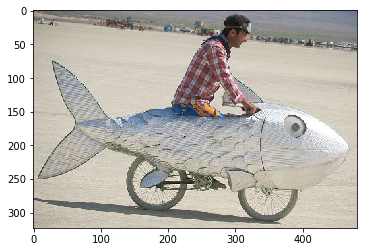

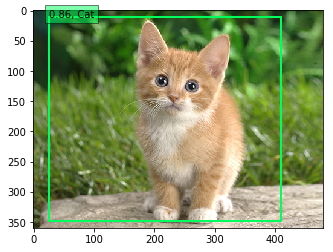

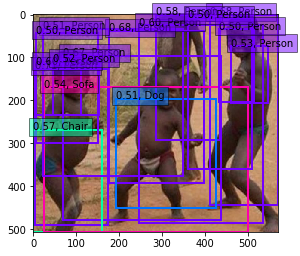

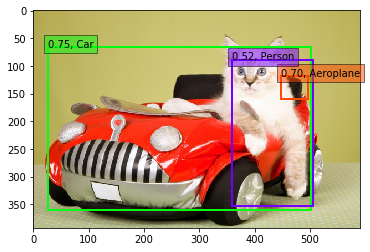

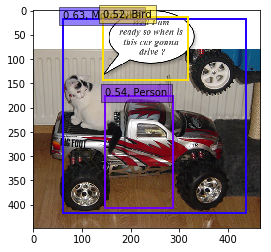

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

In [0]:
!nvidia-smi